# Sequence Final Project - Optimization

## First Approach to the Optimization Problem

### Requirements

In [1]:
from library import init_params
from pyomo.environ import *
import time
import numpy as np
import matplotlib.pyplot as plt
import json
import pandas as pd
import seaborn as sns

### Parameters

In [2]:
# Décommenter la ligne que vous voulez utiliser pour l'instance
instance = "instances/toy_instance.json"
# instance = "instances/medium_instance.json" 
# instance = "instances/large_instance.json"
h,qualif_nb,staff_nb,project_nb,C,CA,N,G,D,R,names = init_params(instance)

### Solving function

In [3]:
def solv_wf(h,staff_nb,qualif_nb,project_nb,CA,N,C,G,D,R):

    # --- 1. Model creation

    model = ConcreteModel()
    # Sets
    model.H = RangeSet(0,h-1)          # Planning Horizon
    model.S = RangeSet(0,staff_nb-1)        # Staff set
    model.P = RangeSet(0,project_nb-1)          # Projects set
    model.Q= RangeSet(0,qualif_nb-1)           # Qualifications set
        
    # Params
    
    model.h = Param(initialize=h)
    model.staff_nb = Param(initialize=staff_nb)
    model.qualif_nb = Param(initialize=qualif_nb)
    model.project_nb = Param(initialize=project_nb)

    # Variables
    
    model.w = Var(model.H, model.P, model.Q, model.S, within=Binary)
    model.y = Var(model.P,within=Binary)
    model.z1 = Var(model.P, within=NonNegativeIntegers, bounds=(0, h-1)) # last day worked on project p
    model.z2 = Var(model.P, within=NonNegativeIntegers, bounds=(0, h-1)) # if not worked on, it is max horizon
    model.z = Var(model.P, within=NonNegativeIntegers, bounds=(0, h-1)) # valeur finale
    model.late = Var(model.P, within=NonNegativeReals)                 # delay in days
    
    # Objective function
    
    def total_profit(model):
        profit = sum(
            model.y[p] * CA[p] - R[p] * model.late[p]
            for p in model.P)
        return profit

    model.obj = Objective(rule=total_profit, sense=maximize)
    
    # Constraints

    ## Constraint on the validation of the projects
    
    def validation_rule(model,p,q):
        return sum(model.w[t,p,q,s] for t in model.H for s in model.S) >= N[p,q] * model.y[p]
    model.validation = Constraint(model.P, model.Q, rule=validation_rule)

    ## Qualification constraint
    def qualification_rule(model,t,p,q,s):
        return  model.w[t, p, q, s] <= C[s, q]
    model.qualification = Constraint(model.H, model.P, model.Q, model.S, rule=qualification_rule)

    ## Day Off constraint
    def day_off_rule(model,t,s):
        return sum(model.w[t,p,q,s] for p in model.P for q in model.Q) <= G[s,t]
    model.day_off = Constraint(model.H, model.S, rule=day_off_rule)

    ## Project completion day (z[p] >= t if any work done on day t)
    def completion_day_rule(model, p, t, q, s):
        return model.z1[p] >= t * model.w[t, p, q, s]
    model.completion_day_1 = Constraint(model.P, model.H, model.Q, model.S, rule=completion_day_rule)


    def completion_max_if_not_selected(model, p):
        return model.z2[p] >= (h-1) * (1 - model.y[p])
    model.completion_max = Constraint(model.P, rule=completion_max_if_not_selected)

    # z[p] >= z1[p]
    def completion_day_rule1(model, p):
        return model.z[p] >= model.z1[p]
    model.completion_day1 = Constraint(model.P, rule=completion_day_rule1)

    # z[p] >= z2[p]
    def completion_day_rule2(model, p):
        return model.z[p] >= model.z2[p]
    model.completion_day2 = Constraint(model.P, rule=completion_day_rule2)

    ## Lateness constraint: late[p] ≥ z[p] - D[p]
    def lateness_rule(model, p):
        return model.late[p] >= model.z[p] - D[p]
    model.lateness = Constraint(model.P, rule=lateness_rule)

    # --- 4. Solve
    
    # Nombre de variables
    num_var = len(list(model.component_data_objects(ctype=pyomo.environ.Var)))
    print("Nombre de variables :", num_var)

    # Nombre de paramètres
    num_param = len(list(model.component_data_objects(ctype=pyomo.environ.Param)))
    print("Nombre de paramètres :", num_param)

    # Nombre de contraintes
    num_constraint = len(list(model.component_data_objects(ctype=pyomo.environ.Constraint)))
    print("Nombre de contraintes :", num_constraint)
    
    start = time.time() 
    solver = SolverFactory("gurobi")  # or 'gurobi' if licensed
    results = solver.solve(model, tee=True)
    end = time.time()
    comp = end-start
    
    # -- 8. Transform it into computable forms
   
    w_arr = np.zeros((h, project_nb, qualif_nb, staff_nb))
    for t in range(h):
        for p in range(project_nb):
            for q in range(qualif_nb):
                for s in range(staff_nb):
                    w_arr[t, p, q, s] = value(model.w[t, p, q, s])

    y_arr = np.zeros(project_nb)
    z_arr = np.zeros(project_nb)
    late_arr = np.zeros(project_nb)

    for p in range(project_nb):
        y_arr[p] = value(model.y[p])
        z_arr[p] = value(model.z[p])
        late_arr[p] = value(model.late[p])

    print("\nValeur optimale :", value(model.obj))
    print("Projets réalisés :", [p for p in range(project_nb) if y_arr[p] == 1])
    print("Temps de calcul :", round(comp, 3), "secondes")

    return value(model.obj), w_arr, y_arr, z_arr, late_arr, comp, num_var, num_param, num_constraint
    

In [4]:
obj,w_arr,y_arr,z_arr,late_arr,comp,num_var,num_param,num_constraint = solv_wf(h,staff_nb,qualif_nb,project_nb,CA,N,C,G,D,R)

Nombre de variables : 250
Nombre de paramètres : 4
Nombre de contraintes : 500
Read LP format model from file /var/folders/z7/f69nzsvj3ng6l90wkyzwbxbm0000gn/T/tmpdt0izw1w.pyomo.lp
Reading time = 0.00 seconds
x1: 500 rows, 250 columns, 1130 nonzeros
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (mac64[x86] - Darwin 21.6.0 21H1123)

CPU model: Intel(R) Core(TM) i5-5350U CPU @ 1.80GHz
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 500 rows, 250 columns and 1130 nonzeros
Model fingerprint: 0xd1e21dc8
Variable types: 5 continuous, 245 integer (230 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+00]
  Objective range  [3e+00, 2e+01]
  Bounds range     [1e+00, 4e+00]
  RHS range        [1e+00, 5e+00]
Found heuristic solution: objective 1.0000000
Presolve removed 466 rows and 152 columns
Presolve time: 0.00s
Presolved: 34 rows, 98 columns, 218 nonzeros
Found heuristic solution: objective 62.0000000
Variable types: 0 continuou

In [5]:
print("z :", z_arr)
print("D",D)
print("late :", late_arr)
print("y :", y_arr)
print("Valeur de l'objectif :", obj)


z : [3. 3. 4. 3. 4.]
D [3 3 4 3 5]
late : [0. 0. 0. 0. 0.]
y : [1. 1. 1. 1. 0.]
Valeur de l'objectif : 70.0


## Visualisation of results

### Visualisation of planning

In [6]:
table = pd.DataFrame(index=names, columns=range(h))

alp = ["A","B","C","D","E","F","G","H","I","J","K","L","M","N","O","P","Q","R","S","T","U","V","W","X","Y","Z"]

for t in range(h):
    for p in range(project_nb):
        for q in range(qualif_nb):
            for s in range(staff_nb):
                if w_arr[t, p, q, s] == 1:
                    table.iloc[s,t] = f"Job {p} {alp[q]}"

# table : DataFrame avec les valeurs "P X Q Y" ou NaN
table_plot = table.fillna("Day Off")

print("Optimization cost :", obj)
print("Computation time (s) :", comp)

Optimization cost : 70.0
Computation time (s) : 1.4426240921020508


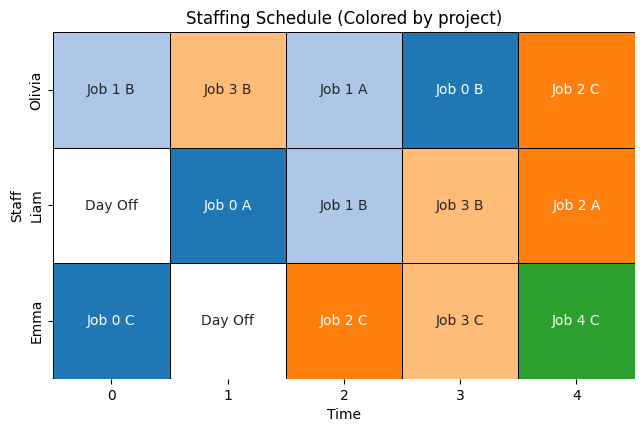

In [8]:
# Extraire uniquement les projets pour le mapping couleur
def extract_project(val):
    if val in ["", "Day Off","No work"]:
        return val
    return val.split()[1]  # "Proj X" → "X"


project_table = table_plot.applymap(extract_project)

# Liste des projets uniques (hors "Day Off" et "No work assigned")
unique_projects = sorted(list(set(v for v in project_table.values.flatten() if v not in ["", "Day Off", "No work"])))

# Mapping projet → entier pour heatmap
project_to_int = {"Day Off": 0, "No work": 1}
project_to_int.update({v: i+2 for i, v in enumerate(unique_projects)})

int_table = project_table.replace(project_to_int).astype(int)

# Palette : blanc pour "Day Off", rouge pour "No work", puis couleurs pour projets
palette = [(1,1,1), (0,0,0)] + sns.color_palette("tab20", len(unique_projects))

# Plot
plt.figure(figsize=(h*1.5, staff_nb*1.5))
ax = sns.heatmap(int_table, annot=table_plot.values, fmt='',
                 cmap=palette,
                 cbar=False,
                 linewidths=0.5, linecolor='black')
        
ax.set_xlabel("Time")
ax.set_ylabel("Staff")
ax.set_title("Staffing Schedule (Colored by project)")
plt.show()